In [1]:
import numpy as np
import pandas as pd
from os import listdir

from os.path import isfile, join
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.transform import resize, rescale
from skimage import filters
from skimage.filters import gaussian
from skimage import morphology
from skimage.color import rgb2gray
from skimage.color import rgb2hsv

In [2]:
def prep_im(im_id, im_dir_path = "", scalar = 1, output_shape = None):
    '''Prepare image from im_id and optional dictory path.
    If directory path is not passed, the whole filepath, including filetype notation, 
    should be given as im_id. If parameter scalar is passed, output image will be scaled by it. 
    Defualt 1 retains original size.
    
    Args:
        im_id (str): image ID
        im_dir_path (str, optional): image directory path
        scalar (float, optional): rescale coefficient

    Returns:
        im (numpy.ndarray): image.
    '''

    # Read and resize image
    if im_dir_path == "":
        im = plt.imread(im_id)[:, :, :3] #Some images have fourth, empty color chanel which we slice of here
    else:
        im = plt.imread(im_dir_path + im_id)[:, :, :3] #Some images have fourth, empty color chanel which we slice of here
    im = rescale(im, scalar, anti_aliasing=True, channel_axis = 2) #IDWE: Use channel_axis=2 to prevent picture from being turned bianry when rescaled
    if output_shape != None:
        im = resize(im, output_shape)

    return im

## Functions for mask generation

In [3]:
def generate_rgb_mask(im):
    val0 = filters.threshold_otsu(im[:,:,0]*256)
    val1 = filters.threshold_otsu(im[:,:,1]*256)
    val2 = filters.threshold_otsu(im[:,:,2]*256)

    #im_mask = (im[:,:,1]*256<val1) & (im[:,:,2]*256<val2)
    im_mask = (gaussian(im[:,:,2]*256,2)>val2+30) 
    
    struct_el = morphology.disk(3)
    im_mask = morphology.binary_opening(im_mask, struct_el)
    
    return im_mask

In [4]:
def generate_mask(im):
    im = rgb2gray(im)*256
    plt.imshow(im, cmap='gray')

    val = filters.threshold_otsu(im)
    im_mask = im < val
    
    struct_el = morphology.disk(3)
    
    im_mask = morphology.binary_opening(im_mask, struct_el)
    
    return im_mask

In [5]:
def generate_gaussian_mask(im):
    im = gaussian(rgb2gray(im)*256, 3)
    
    val = filters.threshold_otsu(im)
    im_mask = im < val
    
    struct_el = morphology.disk(3)
    
    im_mask = morphology.binary_opening(im_mask, struct_el)
    
    return im_mask

In [6]:
def generate_hue_mask(im):
    hsv_im = rgb2hsv(im)
    hue_im = hsv_im[:,:,0]*256
    val_hue = filters.threshold_otsu(hue_im)

    im_hue_mask = (gaussian(hue_im,2) > val_hue)

    struct_el = morphology.disk(3)
    im_hue_mask = morphology.binary_opening(im_hue_mask, struct_el)

    return im_hue_mask

## Make folder for each diagnosis

In [11]:
df = pd.read_csv('metadata.csv')
labels = list(df['diagnostic'])

mask_ack = df[df['diagnostic'] == 'ACK']
mask_bcc = df[df['diagnostic'] == 'BCC']
mask_mel = df[df['diagnostic'] == 'MEL']
mask_nev = df[df['diagnostic'] == 'NEV']
mask_scc = df[df['diagnostic'] == 'SCC']
mask_sek = df[df['diagnostic'] == 'SEK']


paths_ack = mask_ack.img_id.tolist()
paths_bcc = mask_bcc.img_id.tolist()
paths_mel = mask_mel.img_id.tolist()
paths_nev = mask_nev.img_id.tolist()
paths_scc = mask_scc.img_id.tolist()
paths_sek = mask_sek.img_id.tolist()

paths = [paths_ack, paths_bcc, paths_mel, paths_nev, paths_scc, paths_sek]

In [18]:
images_mel = []

for im_path in paths_mel:
    image = prep_im(im_path, "imgs_mel/", output_shape = (300,300))
    arr = np.asarray(image)
    images_mel.append(arr)

In [14]:
len(images_mel)

10

In [20]:
paths_mel[:10]

['PAT_680_1289_182.png',
 'PAT_995_1867_5.png',
 'PAT_966_1825_584.png',
 'PAT_966_1825_546.png',
 'PAT_495_941_26.png',
 'PAT_614_1166_885.png',
 'PAT_340_714_68.png',
 'PAT_115_1138_870.png',
 'PAT_895_1699_872.png',
 'PAT_233_354_935.png']

### Automatic segmentation

In [12]:
def save_mask(im_path, im_mask):
    mask_path = 'imgs_mel/' + '_mask.'.join(im_path.split('.'))
    
    mpimg.imsave(mask_path,im_mask)

In [13]:
for i in range(len(images_mel)):
    im_mask = generate_hue_mask(images_mel[i])
    
    save_mask(paths_mel[i], im_mask)

### Manual segmentation

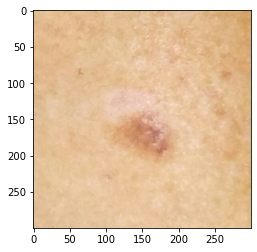

In [28]:
index = paths_mel.index('PAT_233_354_935.png')
im = images_mel[index]

plt.imshow(im)

In [29]:
# Thresholds
im_gray = rgb2gray(im)*256
val = filters.threshold_otsu(im_gray)

val0 = filters.threshold_otsu(im[:,:,0]*256)
val1 = filters.threshold_otsu(im[:,:,1]*256)
val2 = filters.threshold_otsu(im[:,:,2]*256)

190.7498


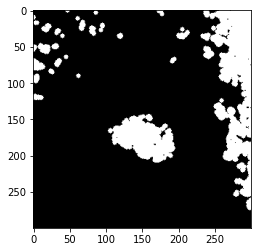

In [30]:
im_mask = (im_gray < val)
print(val)

struct_el = morphology.disk(3)
im_mask = morphology.binary_opening(im_mask, struct_el)
plt.imshow(im_mask, cmap='gray')

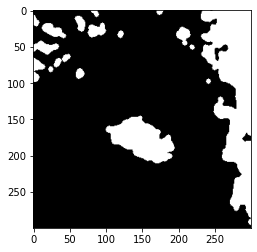

In [31]:
im_rgb_mask = (gaussian(im[:,:,0]*256, 2)<val0) #& (gaussian(im[:,:,1]*256,2)<val1-20)
im_rgb_mask = (gaussian(im[:,:,1]*256,2)<val1)
im_rgb_mask = (gaussian(im[:,:,2]*256,2)<val2-5)

struct_el = morphology.disk(3)
im_rgb_mask = morphology.binary_opening(im_rgb_mask, struct_el)

plt.imshow(im_rgb_mask, cmap='gray')

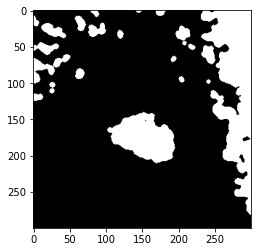

In [33]:
im_g = gaussian(rgb2gray(im)*256, 2)
val_g = filters.threshold_otsu(im_g)
im_g_mask = (im_g < val_g)

struct_el = morphology.disk(3)
im_g_mask = morphology.binary_opening(im_g_mask, struct_el)

plt.imshow(im_g_mask, cmap='gray')

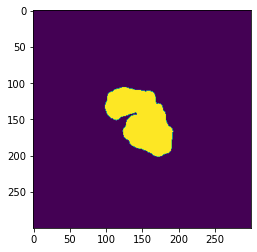

In [36]:
hsv_im = rgb2hsv(im)
hue_im = hsv_im[:,:,0]*256

val_hue = filters.threshold_otsu(hue_im)

im_hue_mask = (gaussian(hue_im,2) < val_hue)

struct_el = morphology.disk(6)
im_hue_mask = morphology.binary_opening(im_hue_mask, struct_el)

plt.imshow(im_hue_mask)

In [1180]:
save_mask('PAT_464_900_548.png', im_g_mask)